# **IEOR 4571 Fall 2020 Homework2 Report**


- Hu, Bo (uni: bh2569)
- Qin, Rui (uni: rq217)
- Yuan, Shuibenyang (uni: sy2938)

In [1]:
%load_ext autoreload
%autoreload 2 

#standard libs
import sys
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from os import path
import matplotlib.pyplot as plt

#plt env
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

#local env
sys.path.append('../')
from src.utils import loading, Spark
data_path = path.join('..', 'data')

# create spark session
spark = Spark()

Spark UI address http://127.0.0.1:4040


# Objective



**Objective function**
We imagine ourselves as owners of a movie catalog website like IMDb or MovieLens. We would want to serve users with movies they like based on their query in the history. The goal is to create lists of movies that users might be interested in. 

**Metrics**

* Root Mean Square Error (RMSE): $RMSE = \sqrt{\frac{\sum_{(u, j) \in E}^{} e_{uj}^2}{\lvert E \rvert}}$, where $e_{ij} = \hat{r}_{uj} - r_{uj}$. E is the neighborhood of our choice.

* Accuracy: We define user rates a movie with scoring larger or equal to 3 as good and smaller to 3 as bad. Ratio of ratings such that both predicted value and actual value larger or equal to 3 or both predicted value and actual value less than 3.

* Coverage: We folloed how Prof. Vintch talked about this metric on piazza. In offline setting, we define coverage as how many movies are recommended over the total number of distinct movies we have in our dataset.

**Intended users**

The recommendation system is created for the general audience so that everyone who enjoys movies benefits from the system.

**Business rules**

In order to keep the user entertained rather than only focusing on what they already know, one business rule we came up with is to include at least two different genres when recommending k movies even though the predicted rating might be low. Since our goal is to benefit all movie lovers, we believe letting them expose to as many genres as possible is fundamental.

**Performance requirements**

For performance, we would like to serve the online queries in real time. For model based algorithms, it’s fine to train it offline and then serve the model online. However, for memory based models, it is hard to meet the performance requirements unless implementing more sophisticated algorithms like approximate nearest neighbor. For this homework, we did not expand our scope on serving in real time. Everything we done was in an offline setting.

**Interpretability**

In order to interpret models better, we decide to make the matrix factorization algorithm to only produce non-negative matrices. In that case, we would be able to identify some elements that are important for the algorithm to learn users’ behaviours (higher value in the matrices would produce higher ratings).

# The Sample

**sampling methodology**

We perform sampling w.r.t Conditional Matrix Sampling, in which, we will sample the matrix of $M$ user indices and $N$ movie indices filtering out users who do not have at least $i$ ratings and movies which do not have at least $j$ ratings. If numbers of users and movies do not meet the minimal requirements $M$ and $N$, we will keep sampling process with increased matrix indices number of user and movie until users and movies meet minimal requirements $M$ and $N$.

**generating sample**

To generate sample, run following lines (The sample has been already stored under `[project_directory]/raw/sample.csv`):

```bash
cd [project_directory]
python main.py download sample
```

## Load Sample

In [2]:
# load sample data from '/data/raw/sample.csv'
datas = loading(spark, path.join(data_path, 'raw'))
sample = datas['sample']
movies = datas['movies']

## Sample Objectives

In [3]:
print(f'''
            number of data points in the sample: {sample.count()},
            number of unique users in the sample: {sample.select('userId').distinct().count()},
            number of unique movies in the sample: {sample.select('movieId').distinct().count()},
            average number of movies a user rated:{sample.groupby('userId').agg(F.count('movieId').alias('cnt')).select(F.mean('cnt')).collect()[0][0]:.2f},
            average number of ratings a movie received: {sample.groupby('movieId').agg(F.count('userId').alias('cnt')).select(F.mean('cnt')).collect()[0][0]:.2f},
            average rating: {sample.select(F.mean('rating')).collect()[0][0]:.2f},
            standard deviation of rating: {sample.select(F.stddev('rating')).collect()[0][0]:.2f},
            average rating by user: {sample.groupby('userId').agg(F.mean('rating').alias('rating')).select(F.mean('rating')).collect()[0][0]:.2f},
            standard deviation of rating by user mean: {sample.groupby('userId').agg(F.mean('rating').alias('rating')).select(F.stddev('rating')).collect()[0][0]:.2f},
            average rating by movie: {sample.groupby('movieId').agg(F.mean('rating').alias('rating')).select(F.mean('rating')).collect()[0][0]:.2f},
            standard deviation of rating by movie mean: {sample.groupby('movieId').agg(F.mean('rating').alias('rating')).select(F.stddev('rating')).collect()[0][0]:.2f}
        ''')


            number of data points in the sample: 444289,
            number of unique users in the sample: 20000,
            number of unique movies in the sample: 1000,
            average number of movies a user rated:22.21,
            average number of ratings a movie received: 444.29,
            average rating: 3.56,
            standard deviation of rating: 1.05,
            average rating by user: 3.69,
            standard deviation of rating by user mean: 0.52,
            average rating by movie: 3.29,
            standard deviation of rating by movie mean: 0.51
        


In [4]:
movies = movies.withColumn("genre_lst",F.split("genres","\|").alias("genre_lst")) # add a new col of genres.split("|")
with_genre = movies.join(sample,movies.movieId == sample.movieId).drop(sample.movieId)
movie_genre = with_genre.select("movieId",F.explode("genre_lst").alias("genre"))
gp_movie_genre = movie_genre.groupBy("genre").agg(F.countDistinct("movieId").alias("cnt"))

In [5]:
print("# of movies in each genre: ")
display(gp_movie_genre.toPandas())

# of movies in each genre: 


,genre,cnt
0,Crime,132
1,Horror,110
2,Adventure,135
3,Sci-Fi,109
4,Musical,34
5,Western,17
6,Comedy,366
7,Mystery,59
8,Romance,140
9,War,39


# Methodology

We implemented two types of collaborative filtering techniques:

- Memory Based Collaborative Filtering
    
- Model Based Collaborative Filtering

## Baseline Model

**usage**

The source code of Baseline Model is under the file directory: `[project_directory]/src/baseline/baseline.py`

To use the predictor, `import Baseline() from src.baseline`

```python
###example
#train_schema: DataFrame[userId: string, movieId: string, rating: string]
#test_schema: DataFrame[userId: string, movieId: string, rating: string]
from src.baseline import Baseline
model = Baseline(base='user', usercol='userId', itemcol='movieId', ratingcol='rating')
model.fit(train)
prediction = model.predict(test)
#prediction_schema: DataFrame[userId: string, movieId: string, rating: float, prediction: float]
   
```

**implementation details**

The baseline model makes simple prediction by taking mean of user mean and item mean:

$R$ is defined as $R_{u,i} = \frac{\mu_u + \mu_i}{2}$ where u and i represents user and item accordingly.

## Memory Based Collaborative Filtering

**usage**

The source code of Memory Based Collaborative Filtering is under the file directory: `[project_directory]/src/memory_based/memory_based_cf.py`. 

To use the predictor, `import Memory_based_CF() from src.memory_based`

```python
###example
#spark: the spark session
#train_schema: DataFrame[userId: string, movieId: string, rating: string]
#test_schema: DataFrame[userId: string, movieId: string, rating: string]
from src.memory_based import Memory_based_CF
#user based
model = Memory_based_CF(spark, base='user', usercol='userId', itemcol='movieId', ratingcol='rating')
model.fit(train)
prediction = model.predict(test)
#item based
model = Memory_based_CF(spark, base='item', usercol='userId', itemcol='movieId', ratingcol='rating')
model.fit(train)
prediction = model.predict(test)
#prediction_schema: DataFrame[userId: string, movieId: string, rating: float, prediction: float]
   
```


**implementation details**

The data first transformed into sparse matrix representation, (user by item) if user based and (item by user) if item based.

The the prediction matrix $R$ is trained with following formula:

$R$ is defined as $R_{i, j} = \mu_i + \frac{\sum_{v\in P_i(j)}S(i, v)\cdot (r_{vj} - \mu_v)}{\sum_{v\in P_i(j)}|S(i, v)|}$

where $S$ is the Pearson Similarity Matrix

$S$ is defined as $S_{u,v} = \frac{\sum_{k\in I_u \cap I_v}(r_{uk} - \mu_u)(r_{vk} - \mu_v)}{\sqrt{\sum_{k\in I_u \cap I_v}(r_{uk} - \mu_u)^2}\sqrt{\sum_{k \in I_u \cap I_v}(r_{vk} - \mu_v)^2}}$

The algorithm is implemented with numpy array (for prediction) and scipy csr sparse matrix (for training). 

Every operation uses numpy matrix operations (aka. dot product, norm, etc) which optimizes the computational speed by trading off extra memories (for loop takes $\approx 10$ minutes to train and matrix operations takes $\approx 1$ minutes to train for our experimental sample in user based CF).

**user based collabrative filtering**

When R is (user by item) and S is (user by user), it is User Based Collabrative Filtering

**item based collabrative filtering**

When R is (item by user) and S is (item by item), it is Item Based Collabrative Filtering


## Model Based Collaborative Filtering

**usage**

The source code of Memory Based Collaborative Filtering is under the file directory: `[project_directory]/src/model_based/als.py`. 

To use the predictor, just `import Als() from src.model_based`

```python
###example
#train_schema: DataFrame[userId: string, movieId: string, rating: string]
#test_schema: DataFrame[userId: string, movieId: string, rating: string]

from src.model_based import Als

model = Als(userCol='userId', itemCol='movieId', ratingCol='rating', regParam=.01, seed=0, rank=10)
model.fit(train)
prediction = model.predict(test)

#prediction_schema: DataFrame[userId: string, movieId: string, rating: float, prediction: float]
   
```


**implementation details**

The data first casted userId and movieId into integers and then fit into `pyspark.ml.recommendation.ALS`.

Our implementation takes advantages of model based collaborative filtering algorithm implemented in `spark.ml`, in which users and products are described by a small set of latent factors that can be used to predict missing entries `spark.ml` uses the alternating least squares (ALS) algorithm to learn these latent factors.

Since there are many parameters in ALS of `spark.ml`, we will fix `nonnegative = True` in order to increase interpertability, and we will only select `regParam`(scale of regulization term) and `rank`(number of hidden factors) to be tuned. (We also tried to tune `maxIter` parameter, but when `maxIter > 20` will blow up memory in our machine with large `rank`, and it takes much longer with nearly the same results, so we will keep `maxIter` with default `=10`.)

# Evaluation

## Cross Validation Setup

**general setup**

we will first setup a fixed splitted dataset for all models: baseline, memory-based CF, and model-based CF.

With following splits based on every user:
- train, test : $75\%, 25\%$
- train, test : $50\%, 50\%$
- train, test : $25\%, 75\%$

For example, for (train, test: $75\%, 25\%$), we will retain first (older to newer) $75\%$ of every user's rating w.r.t their rating time as train set, and we will take the rest as test set.

The splitted data has already been stored under the file directory `[project_directory]/data/interim/`. The file alias following the pattern: `[train/test]_[0.xx_0.xx].csv`. For example, `train_0.75_0.25.csv` means the training set with $75\%$ train and $25\%$ test split.

To generate the splitted data, run following lines in bash:

```bash
cd [project_directory]
python main.py train-test-split
```


In [6]:
data = loading(spark, '../data/interim')
splits = ['0.75_0.25', '0.5_0.5', '0.25_0.75']
for split in splits:
    print(f'''
            number of rows in train set of {split}: {data['train_'+split].count()},
            number of rows in test set of {split}:  {data['test_'+split].count()}
            ''')


            number of rows in train set of 0.75_0.25: 339624,
            number of rows in test set of 0.75_0.25:  104665
            

            number of rows in train set of 0.5_0.5: 226271,
            number of rows in test set of 0.5_0.5:  218018
            

            number of rows in train set of 0.25_0.75: 118148,
            number of rows in test set of 0.25_0.75:  326141
            



**model based CF**

For model based CF, we will do additional hyper-parameter tuning with $10\%$ validation set from train set to get the best possible parameter.

## Evaluation Metrics

Our metrics are as follow:

* Root Mean Square Error (RMSE): $RMSE = \sqrt{\frac{\sum_{(u, j) \in E}^{} e_{uj}^2}{\lvert E \rvert}}$, where $e_{ij} = \hat{r}_{uj} - r_{uj}$.

* Accuracy: We define a user rates a movie with score larger or equal to 3 as good and smaller 3 as bad. Ratio of ratings such that both predicted value and actual value larger or equal to 3 or both predicted value and actual value less than 3.

* Coverage: We folloed how Prof. Vintch talked about this metric on piazza. In offline setting, we define coverage as how many movies are recommended over the total number of distinct movies we have in our dataset.

## Parameter Tuning for ALS

we used following parameters as our grid search for paramerter tuning with $10\%$ validation set of train set to get the best possible parameter of `regParam` and `rank`

``` json
parameters = {
    "regParam": [0.01, 0.05, 0.1, 0.15],
    "rank": [10, 50, 100, 150, 200]
}
```

The details of parameter turning can be found in this [notebook](./als_parameter_tuning.ipynb)

In [7]:
tuning_res = pd.read_csv(path.join(data_path, 'processed', 'tuning_result','als_parameter_tuning.csv'))
tuning_res['regParam'] = tuning_res['(regParam, rank)'].str.strip('()').str.split(',').str[0].astype(float)
tuning_res['rank'] = tuning_res['(regParam, rank)'].str.strip('()').str.split(',').str[1].astype(int)
tuning_res = tuning_res.set_index('(regParam, rank)')

**the best paramter**

In [8]:
optimals = []
tb_optimal = pd.DataFrame(columns =  ['0.75_0.25', '0.5_0.5', '0.25_0.75'])
for split in ['0.75_0.25', '0.5_0.5', '0.25_0.75']:
    subset = tuning_res[tuning_res.split == split].drop('split', axis = 1)
    for col in ['rmse', 'accuracy']:
        if col == 'rmse':
            optimal = subset[col].idxmin()
        else:
            optimal = subset[col].idxmin()
        tb_optimal.loc[col, split] = optimal    
        optimals.append(optimal)
print('the optimal parameter table for each split')
display(tb_optimal)

the optimal parameter table for each split


,0.75_0.25,0.5_0.5,0.25_0.75
rmse,"(0.15, 10)","(0.15, 10)","(0.15, 10)"
accuracy,"(0.01, 50)","(0.05, 50)","(0.05, 50)"


The best parameter for ALS is regparam = 0.15 and rank = 10 since it has the best performance on our primary metric RMSE.

## Evaluation Execution

To reduce the tediousness of final report, please see the process of Evaluation Executation in this [notebook](./evaluation_execution.ipynb)

## Evaluation Results w.r.t metrics

In [9]:
#loading results
results = loading(spark, path.join(data_path, 'processed', 'evaluation_result'))
for k in results.keys():
    results[k] = results[k].toPandas()
    results[k].columns = ['metrics', 'train', 'test', 'split']
grouped_results = {'rmse': pd.DataFrame(columns = ['model', 'train_proportion', 'train_rmse', 'test_rmse']),
                   'accuracy': pd.DataFrame(columns = ['model', 'train_proportion', 'train_accuracy', 'test_accuracy']),
                   'coverage_user':pd.DataFrame(columns = ['model', 'train_proportion', 'train_coverage_user', 'test_coverage_user']),
                   'coverage_item': pd.DataFrame(columns = ['model', 'train_proportion', 'train_coverage_item', 'test_coverage_item'])
                }

for metric in ['rmse', 'accuracy']:
    for split, prop_train in zip(['0.75_0.25', '0.5_0.5', '0.25_0.75'], [.75, .5, .25]):
        for model in ['baseline', 'userbased', 'itembased', 'modelbased']:
            df = results[model+'_eval_res']
            res = df[(df.split == split) & (df.metrics == metric)]
            ds = pd.Series({
                'model': model,
                'train_proportion': prop_train,
                'train_'+ metric:round(float(res.iloc[0].loc['train']), 2),
                'test_'+metric: round(float(res.iloc[0].loc['test']), 2)
            })
            grouped_results[metric] = grouped_results[metric].append(ds, ignore_index=True)

def mean_metrics(df, metric):
    return df.groupby('model')[['train_'+metric, 'test_'+metric]].mean().round(2)

def plot_split_metric(df, metric):
    for model in df.model.unique():
        subset = df[df.model == model]
        plt.plot(subset.train_proportion, subset['train_'+metric], label = model)
        plt.legend()
    plt.title(f'train {metric} vs. training proportion')
    plt.ylabel(f'train {metric}')
    plt.xlabel('train proportion')
    plt.show()
    for model in df.model.unique():
        subset = df[df.model == model]
        plt.plot(subset.train_proportion, subset['test_'+metric], label = model)
        plt.legend()
    plt.title(f'test {metric} vs. training proportion')
    plt.ylabel(f'test {metric}')
    plt.xlabel('train proportion')
    plt.show()

### RMSE Results

**mean train rmse and test rmse with different models**

In [10]:
rmse_grouped_results = grouped_results['rmse']
display(mean_metrics(rmse_grouped_results, 'rmse'))

,train_rmse,test_rmse
model,,
baseline,0.85,0.92
itembased,0.89,0.91
modelbased,0.63,0.94
userbased,0.80,0.93


From the table above, item-based CF has the lowest mean test rmse across all the splits. Despite the lower train rmse of user-based CF, item-based CF outperforms user-based CF with 0.02 lower test rmse. In our case study, we have 20000 users and 1000 items, since the dataset is relatively small compared to common larger dataset, the performance of user-based recommenders keeps improving as neighborhood sizes are increased. For model based CF, we see although it has a very poor performance in train rmse, but it is able to generalize well in our test set.

**train rmse and test rmse with different training proportion across different models**

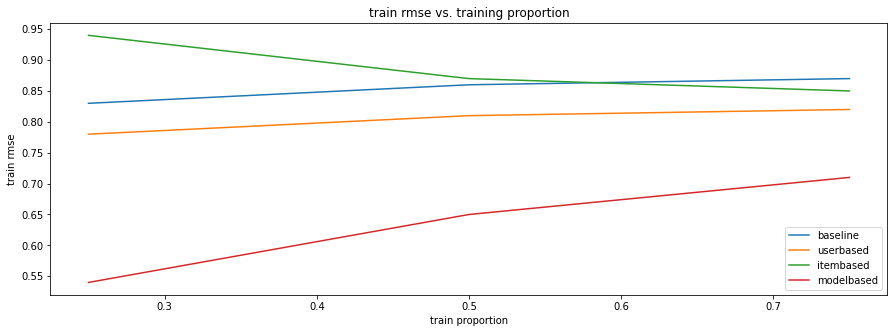

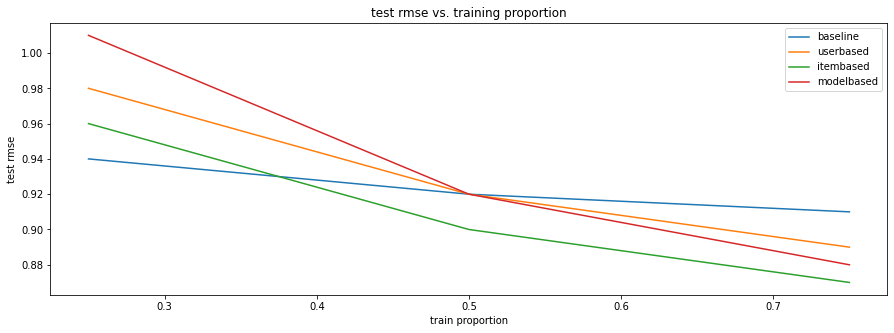

In [11]:
plot_split_metric(rmse_grouped_results, 'rmse')

To get a deeper view of how the train, test rmse change depends on the sample size, we plot how train, test rmse change based on different training proportions. From the plot, when the training sample is $25\%$, model-based CF performs the worst with large sign of over-fitting, and baseline model performs the best. As the size of train proportion increases, item-based CF will outperform all others. We hypothesis that as the training size getting larger and larger, model-based CF will outperform memmory-based CF. This needs larger sample to confirm in the future.

### Accuracy Results

In [12]:
accuracy_grouped_results = grouped_results['accuracy']
display(mean_metrics(accuracy_grouped_results, 'accuracy'))

,train_accuracy,test_accuracy
model,,
baseline,0.87,0.83
itembased,0.84,0.80
modelbased,0.86,0.74
userbased,0.85,0.79


We see that the baseline model outperforms other models, and it is not we expected as RMSE results sugget above. We make hypothesis that our cutting point `3` will not get an effecient division of users rating: people are more likely to rate score around `3`, thus making the detection of accuracy not robust. To get further investigation of people's rating w.r.t to cutting point, we will discuss Prediction and Rating distribution in [Prediction Distribution](#Prediction-Distribution) section below.

**train accuracy and test accuracy with different training proportion across different models**

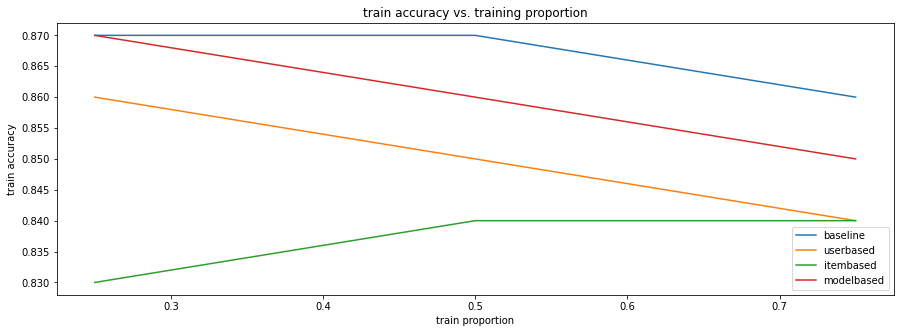

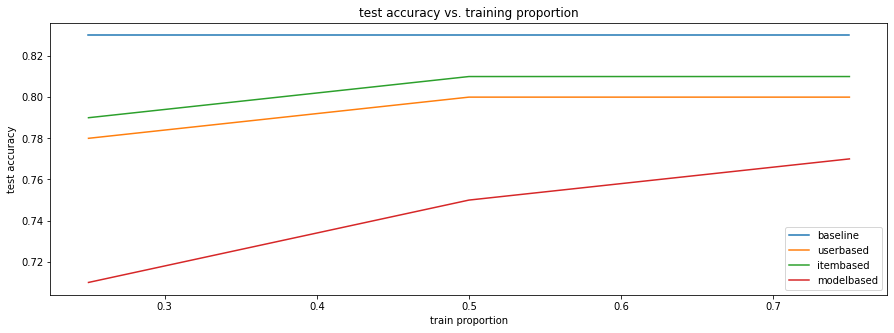

In [14]:
plot_split_metric(accuracy_grouped_results, 'accuracy')

From the plot, baseline model outperforms in all train-test-split, but as the proportion of training sample increases, the accuracy of other models will also increase. We suggest that with more and more sample be trained, accuracy will also increase. But still, we doubt the cutting point `3`, so see the [Prediction Distribution](#Prediction-Distribution) section below for futher investigation about the labels. 

### Coverage Results

The details of coverage evaluation execution is in this [notebook](coverage_execution.ipynb)

In [16]:
coverage = pd.read_csv(path.join(data_path, 'processed', 'evaluation_result', 'coverage.csv'))

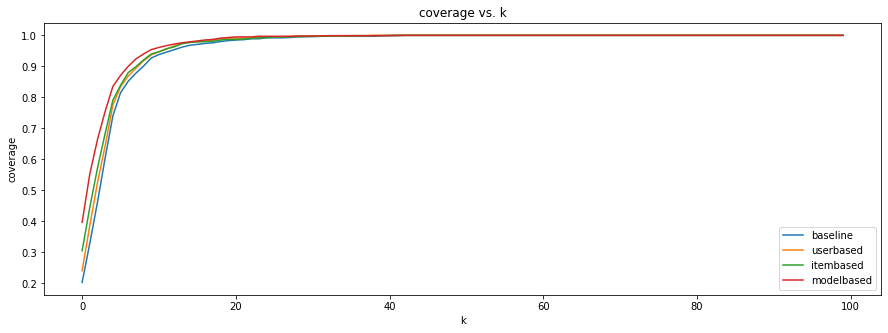

In [17]:
coverage.plot()
plt.title('coverage vs. k')
plt.xlabel('k')
plt.ylabel('coverage')
plt.show()

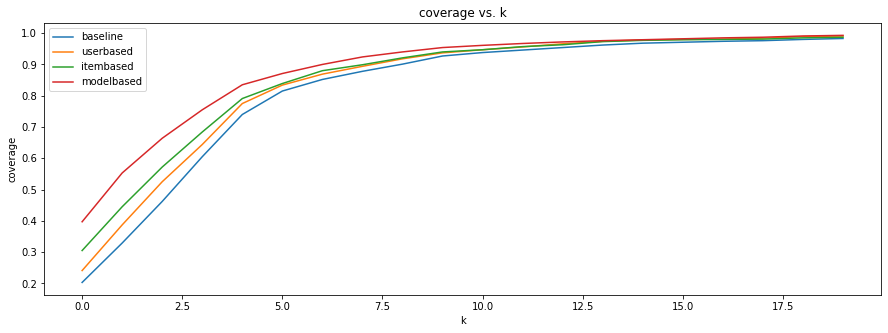

In [18]:
coverage.iloc[:20, :].plot()
plt.title('coverage vs. k')
plt.xlabel('k')
plt.ylabel('coverage')
plt.show()

When k goes beyond 10, all the models will nearly to cover all the items in the itemset. When k = 1, model-based CF will cover all the most items in the itemset, and baseline covers the least items in the itemset. 

## Evaluation Results w.r.t time

In [19]:
#loading result and process the result into format
time_res = {model : pd.read_csv(path.join(data_path, 'processed', 'evaluation_result', model+'_time_res.csv'))\
 for model in ['baseline', 'userbased', 'itembased', 'modelbased']}
for k in time_res.keys():
    time_res[k].columns = ['stage', 0.75, 0.5, 0.25]
    time_res[k] = time_res[k].set_index('stage')
mean_time = pd.DataFrame(columns = ['baseline', 'userbased', 'itembased', 'modelbased'])
for model in ['baseline', 'userbased', 'itembased', 'modelbased']:
    mean_time[model] = time_res[model].mean(axis =1)

**mean training/inference time of different models**

In [20]:
display(mean_time)

,baseline,userbased,itembased,modelbased
stage,,,,
training time,0.075200,35.892127,5.336622,2.412108
inference train time,0.045296,7.247158,7.282374,0.020757
inference test time,0.043647,6.764269,6.833395,0.021495


From the table above, we see that baseline model has the lowest time cost in training and inference time because of the naive algorithm. Except baseline model, model-based CF has the lowest training time and inference time because of the optimization of ALS algorithm. 

**time scalibility**

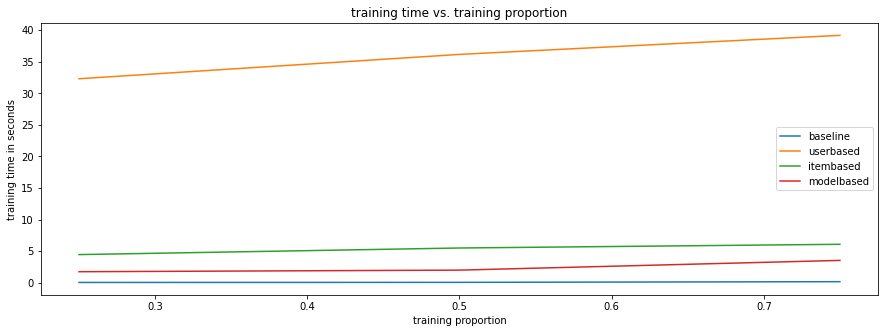

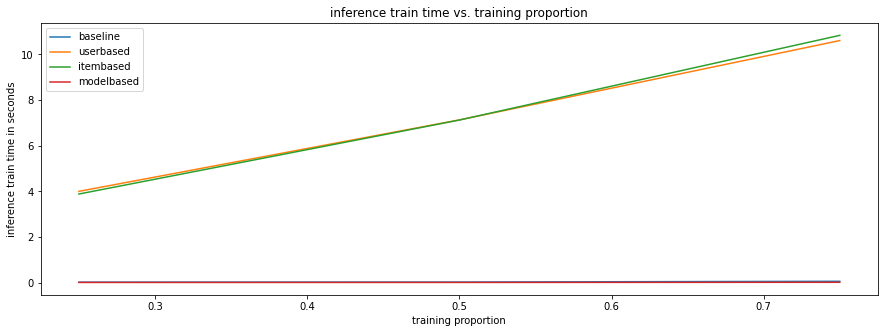

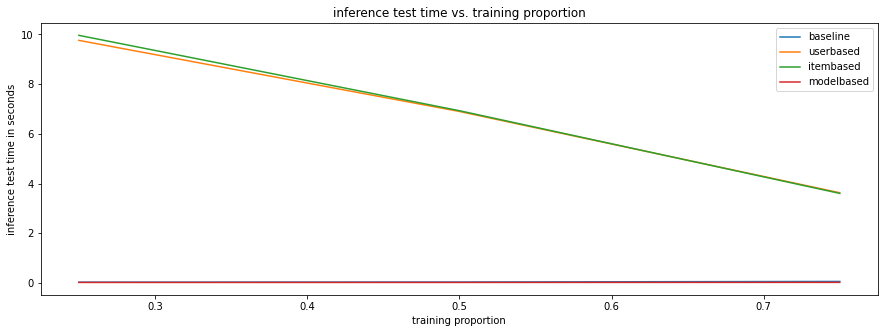

In [21]:
for stage in ['training time', 'inference train time', 'inference test time']:
    pd.DataFrame({model: time_res[model].T[stage]\
    for model in ['baseline', 'userbased', 'itembased', 'modelbased']}).plot()
    plt.title(f'{stage} vs. training proportion')
    plt.ylabel(f'{stage} in seconds')
    plt.xlabel('training proportion')
    plt.show()

From the plots above, user-based CF has the poorest scalibility in term of training time: the more users there are in the system, the greater the cost of finding simularity and prediction matrix. For inference time, both item-based and user-based CF have poor inference time scalibility since it needs to take $O(n)$ time to seek the entry in the prediction matrix. 

## Prediction Distribution

In [22]:
predictions = loading(spark, path.join(data_path, 'processed', 'prediction'))

for k in predictions.keys():
    predictions[k] = predictions[k].select('userId', 'movieId', 
                                           F.col('rating').cast('float'), 
                                           F.col('prediction').cast('float'))\
                                    .toPandas()

In [23]:
def rating_distribution(raw):
    fig, ax = plt.subplots(1,1)
    raw.prediction.plot(kind='hist',bins=np.arange(0,6,0.5),ax=ax,alpha=0.7,density=True,label='predicted')
    raw.rating.plot(kind='hist',bins=np.arange(0,6,0.5),ax=ax,alpha=0.7,density=True,label='actual')
    plt.legend()
    plt.xlabel("Ratings")
    plt.ylabel("% of Ratings")
    plt.title("Distribution of Actual Ratings vs. Predicted Ratings")
    plt.show()
    return

def plot_pipeline(splits, model, predictions):
    for s in splits:
        print(f'with {s} split, the plot of distribution is: ')
        k = s + '_' + model + '_' + 'pred'
        rating_distribution(predictions[k])

### Baseline Model Prediction Distribution

with 0.75_0.25 split, the plot of distribution is: 


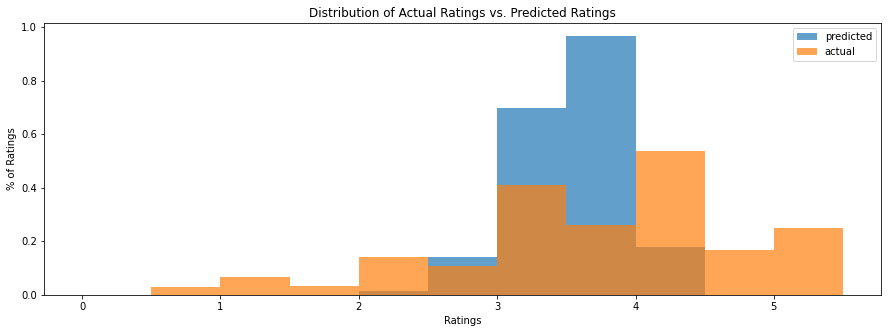

In [24]:
plot_pipeline(['0.75_0.25'], 'baseline', predictions)

From the graph above, we notice that when using baseline model, predicted values of ratings tend to have a lower variance than actual values, that is predicted values tend to be closer to each other. 

### User Based CF Prediction Distribution

with 0.75_0.25 split, the plot of distribution is: 


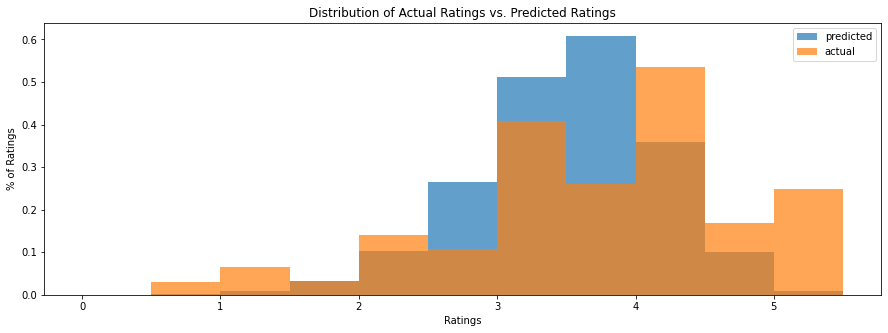

In [25]:
plot_pipeline(['0.75_0.25'], 'userbased', predictions)

From the graph above, it is observed that predicted ratings by user based CF has a distribution not quite the same as the actual ratings. The distribution of predicted ratings tend to be symmetric while actual ratings is left skewed.

### Item Based CF Prediction Distribution

with 0.75_0.25 split, the plot of distribution is: 


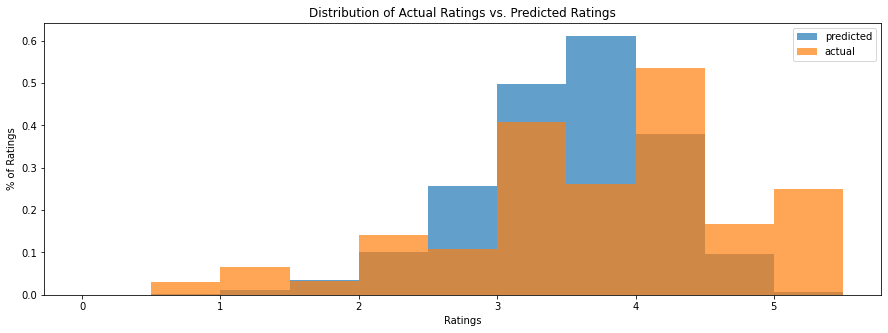

In [26]:
plot_pipeline(['0.75_0.25'], 'itembased', predictions)

Similiar to user based CF, predicted ratings by item based CF has a distribution different from the actual ratings. The distribution of predicted ratings tend to be symmetric while actual ratings is left skewed.

### Model Based CF Prediction Distribution

with 0.75_0.25 split, the plot of distribution is: 


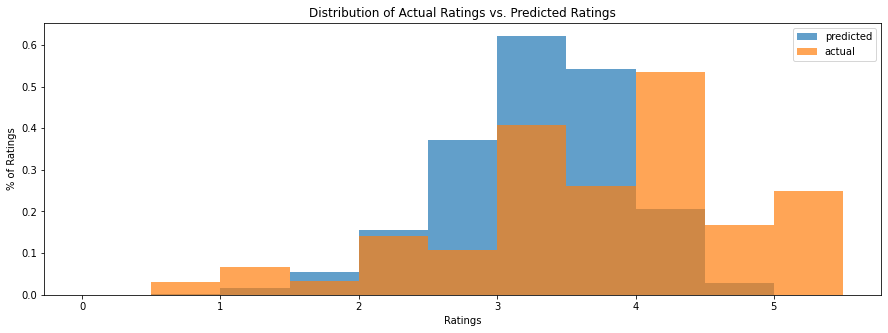

In [27]:
plot_pipeline(['0.75_0.25'], 'modelbased', predictions)

From the graph above, we notice that predicted ratings tend to have lower mean than the actual ratings and the variance of predicted ratings is slightly smaller than the actual values.

One common problem for all the models we selected is that: they tend to rate the movies conservatively. Most of the score that models gave are close to 3 or 3.5 (covers more than half of all ratings models gave). In reality, we could see that this group of users tend to rate movies with 3 or 4 rather 3.5. Since our metric is to reduce the distance between the actual ratings and the predicted ratings, it makes sense that our models giving score of 3.5 so that they could strictly follow the task.

## Prediction w.r.t Movie Genre (hypothesis)

In [28]:
movies = spark.read.csv(path.join(data_path, 'raw', 'movies.csv'),header=True)

predictions_spark = loading(spark, path.join(data_path, 'processed', 'prediction'))

for k in predictions_spark.keys():
    predictions_spark[k] = predictions_spark[k].select('userId', 'movieId', 
                                           F.col('rating').cast('float'), 
                                           F.col('prediction').cast('float'))

# helper to append genre to rating table
def append_genre(sample):
    copy = movies.withColumn("genre_lst",F.split("genres","\|").alias("genre_lst")) # add a new col of genres.split("|")
    with_genre = copy.join(sample,copy.movieId == sample.movieId).drop(sample.movieId)
    movie_genre = with_genre.select("movieId",F.explode("genre_lst").alias("genre"),"rating","prediction")
    return movie_genre

# func to create the table with genre, mean ratings, and mean pred
def mean_by_genre(with_pred):
    with_genre = append_genre(with_pred)
    avg = with_genre.groupBy("genre").agg(F.mean("rating").alias("avg_rating"),F.mean("prediction").alias("avg_prediction"))
    return avg

# func to plot 
def draw_mean_genre(avg):
    fig, ax = plt.subplots(1,1,figsize=(12,5))
    avg.toPandas().plot(x='genre',y=['avg_rating','avg_prediction'],kind='bar',ax=ax)
    plt.ylabel("rating")
    plt.legend(loc='lower right')
    plt.title("Average Ratings and Predictions for Genres")
    plt.show()
    return

def plot_genre(splits, model, predictions):
    for s in splits:
        print(f'with {s} split, the plot of distribution is: ')
        k = s + '_' + model + '_' + 'pred'
        draw_mean_genre(mean_by_genre(predictions_spark[k]))

### Baseline Prediction with Genre

with 0.75_0.25 split, the plot of distribution is: 


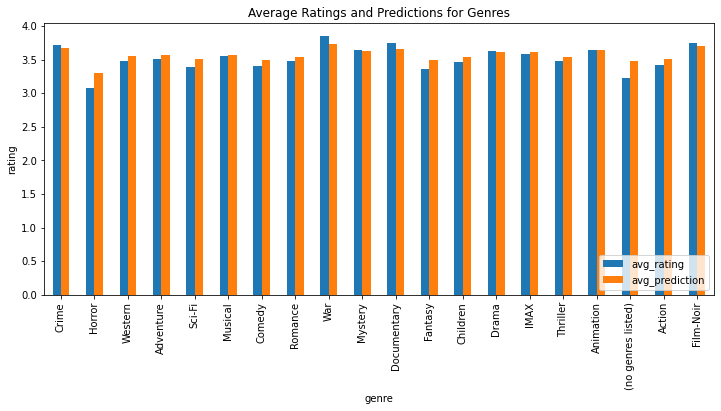

In [29]:
plot_genre(['0.75_0.25'], 'baseline', predictions)

It can be seen that the average ratings and the average predictions by baseline model are about the same. The average ratings and average predictions have the largest difference on movies with no genre listed. On the other hand, the average ratings and predictions on animation are the same.

### User Based CF Prediction with Genre

with 0.75_0.25 split, the plot of distribution is: 


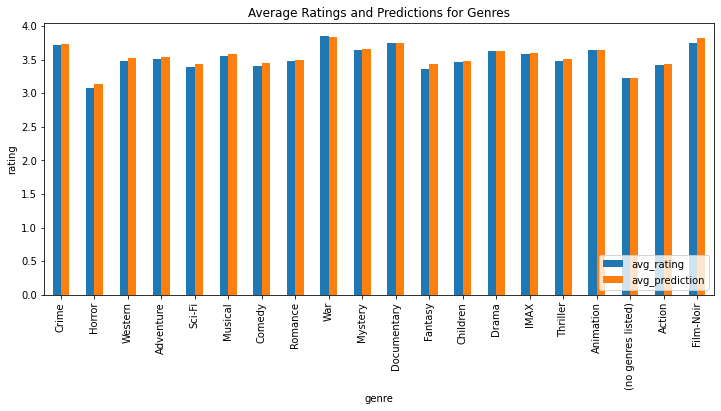

In [30]:
plot_genre(['0.75_0.25'], 'userbased', predictions)

Compared with baseline model, average predictions by the user based CF and average ratings are about the same on most genre. Specifically, we notice that movies with no genre listed have the same value for predicted and actual ratings.

### Item Based CF Prediction with Genre

with 0.75_0.25 split, the plot of distribution is: 


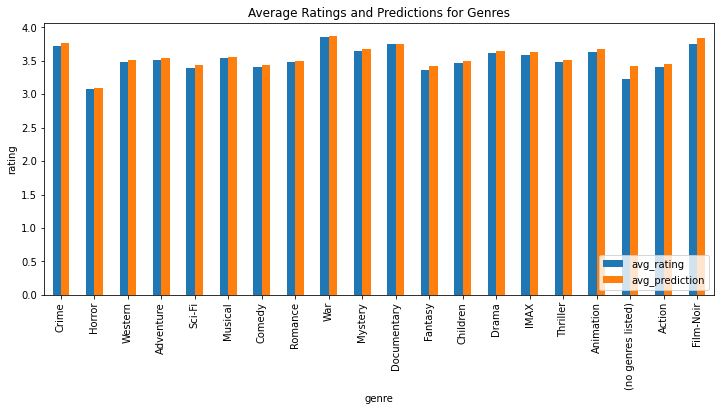

In [31]:
plot_genre(['0.75_0.25'], 'itembased', predictions)

Similar to user based CF, the item based CF has average predictions about the same as average ratings. However, the average prediction and average rating has a significant difference on movies with no genres listed.

### Model Based CF Prediction with Genre

with 0.75_0.25 split, the plot of distribution is: 


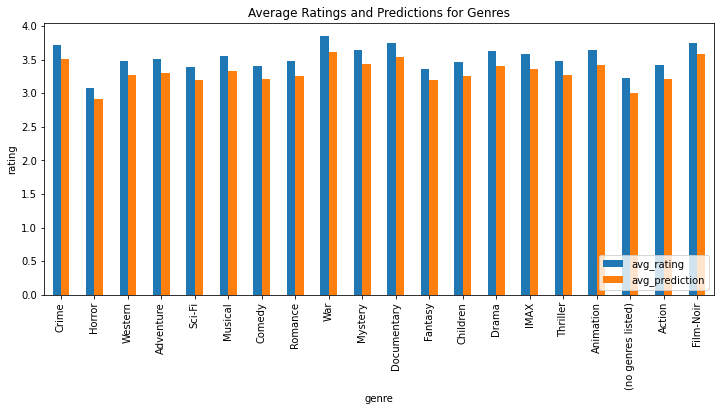

In [32]:
plot_genre(['0.75_0.25'], 'modelbased', predictions)

Compared with other two graphs above, model based CF tend to have higher average predictions than average ratings. Also, for many genres, we could see significant difference between average ratings and average predictions.

## The Loss User

In this section, we try to pick out the user with the highest mse. We would want to see what causes the models perform poorly on this target, so that we could make improvement later on.

In [33]:
predictions_spark = loading(spark, path.join(data_path, 'processed', 'prediction'))

In [34]:
def loss_user(with_pred,minloss=True):
    with_se = with_pred.withColumn("SE",(with_pred.rating - with_pred.prediction)**2)
    with_mse = with_se.groupBy("userID").agg(F.mean("SE").alias("MSE")).orderBy("MSE",ascending=minloss)
    user = with_mse.take(1)[0][0]
    mse = with_mse.take(1)[0][1]
    print("MSE for this user is: "+str(mse))
    return with_pred[with_pred.userId == user]

def loss_user_pipeline(splits, model, predictions):
    for s in splits:
        print(f'with {s} split, the plot of distribution is: ')
        k = s + '_' + model + '_' + 'pred'
        display(loss_user(predictions_spark[k], False).toPandas())

### The Loss User for Baseline Model

In [35]:
loss_user_pipeline(['0.75_0.25'], 'baseline', predictions)

with 0.75_0.25 split, the plot of distribution is: 
MSE for this user is: 14.22008875266121


,userId,movieId,rating,prediction
0,69944,1148,0.5,4.270953294945618


### The Loss User for User Based CF

In [36]:
loss_user_pipeline(['0.75_0.25'], 'userbased', predictions)

with 0.75_0.25 split, the plot of distribution is: 
MSE for this user is: 18.467031298210507


,userId,movieId,rating,prediction
0,69944,1148,0.5,4.797328390780778


### The Loss User for Item Based CF

In [37]:
loss_user_pipeline(['0.75_0.25'], 'itembased', predictions)

with 0.75_0.25 split, the plot of distribution is: 
MSE for this user is: 19.351978258550428


,userId,movieId,rating,prediction
0,69944,1148,0.5,4.89908834402657


### The Loss User for Model Based CF

In [38]:
loss_user_pipeline(['0.75_0.25'], 'modelbased', predictions)

with 0.75_0.25 split, the plot of distribution is: 
MSE for this user is: 17.106355376289002


,userId,movieId,rating,prediction
0,120376,1270,0.5,4.635983


We observe that the user with id 69944 has the highest mse for all the models when rating movie 1148. Our models performs badly for this user might have a few reasons: 1. this user has very few rating that our model could memorize. 2. this user gave the movie a really low score, which is opposite from most of the users in this group of sample (our mean rating is about 3.56 for this group). Fortunately, our baseline model picked up his behavior but still the model did not reflect his aggressiveness.  

## Conclusion

* After seeing these results, what other design choices might you consider in order to have a more accurate or more useful model?

Inspired from the loss user section, in this project, our model performs poorly on the examples which the user would give extreme scores.

Later on, we should develope methods to early detect the appearance of extreme scores. For example, if we could use side information, such as, news about a bloackbuster or lots of bad reviews on a movie, then we should be able to tell the model to potentially hand out some extreme scores.

* How does your recommendation system meet your hypothetical objectives? Would you feel comfortable putting these solutions into production at a real company? What would be the potential watch outs?

I think our models would perform the desired task moderately. Although they are not able to handle extreme cases well, the models could serve general users in a good manner. One important watch out would be the miss treatment of new users. Our recommendation system did not consider the case when a brand new user entering in. For this problem, we have two solutions: 1. serve new users with the most popular movies 2. let incoming users do a survey first and we could mark some movies for them so that they become existed users in the system.

* What is your final recommendation to your manager?

Our project would be a good start for a future more sophisticated system. From the predictions' distribution, we could see that these models would rate movies around 3.5 and seldom extreme scores. For general users, this could be considered a moderate model to be productionized. For now, as we are still at the begining stage with not many users, this model would handle their queries effectively. Once we have a increased user base, these models would need to be scale up in order to handle large volume.